# Final Project - Sleep Study

Before we begin looking at data, let's import some libraries for this project.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn.model_selection
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm

### 1. Data Collection

This project is using the Sleep Eficiency Dataset from Kaggle which can be found at https://www.kaggle.com/datasets/equilibriumm/sleep-efficiency . Let's import the csv file and take a precursory look at the variables.

In [164]:
df = pd.read_csv('Sleep_Efficiency.csv')
df.describe()

,ID,Age,Gender,Sleep_duration,Sleep_efficiency,REM_sleep_percentage,Deep_sleep_percentage,Light_sleep_percentage,Awakenings,Caffeine_consumption,Alcohol_consumption,Smoking_status,Exercise_frequency
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,432.000000,427.000000,438.000000,452.000000,446.000000
mean,226.500000,40.285398,0.495575,7.465708,0.788916,22.615044,52.823009,24.561947,1.641204,23.653396,1.173516,0.340708,1.791480
std,130.625419,13.172250,0.500534,0.866625,0.135237,3.525963,15.654235,15.313665,1.356762,30.202785,1.621377,0.474472,1.428134
min,1.000000,9.000000,0.000000,5.000000,0.500000,15.000000,18.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,113.750000,29.000000,0.000000,7.000000,0.697500,20.000000,48.250000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,226.500000,40.000000,0.000000,7.500000,0.820000,22.000000,58.000000,18.000000,1.000000,25.000000,0.000000,0.000000,2.000000
75%,339.250000,52.000000,1.000000,8.000000,0.900000,25.000000,63.000000,32.500000,3.000000,50.000000,2.000000,1.000000,3.000000
max,452.000000,69.000000,1.000000,10.000000,0.990000,30.000000,75.000000,63.000000,4.000000,200.000000,5.000000,1.000000,5.000000


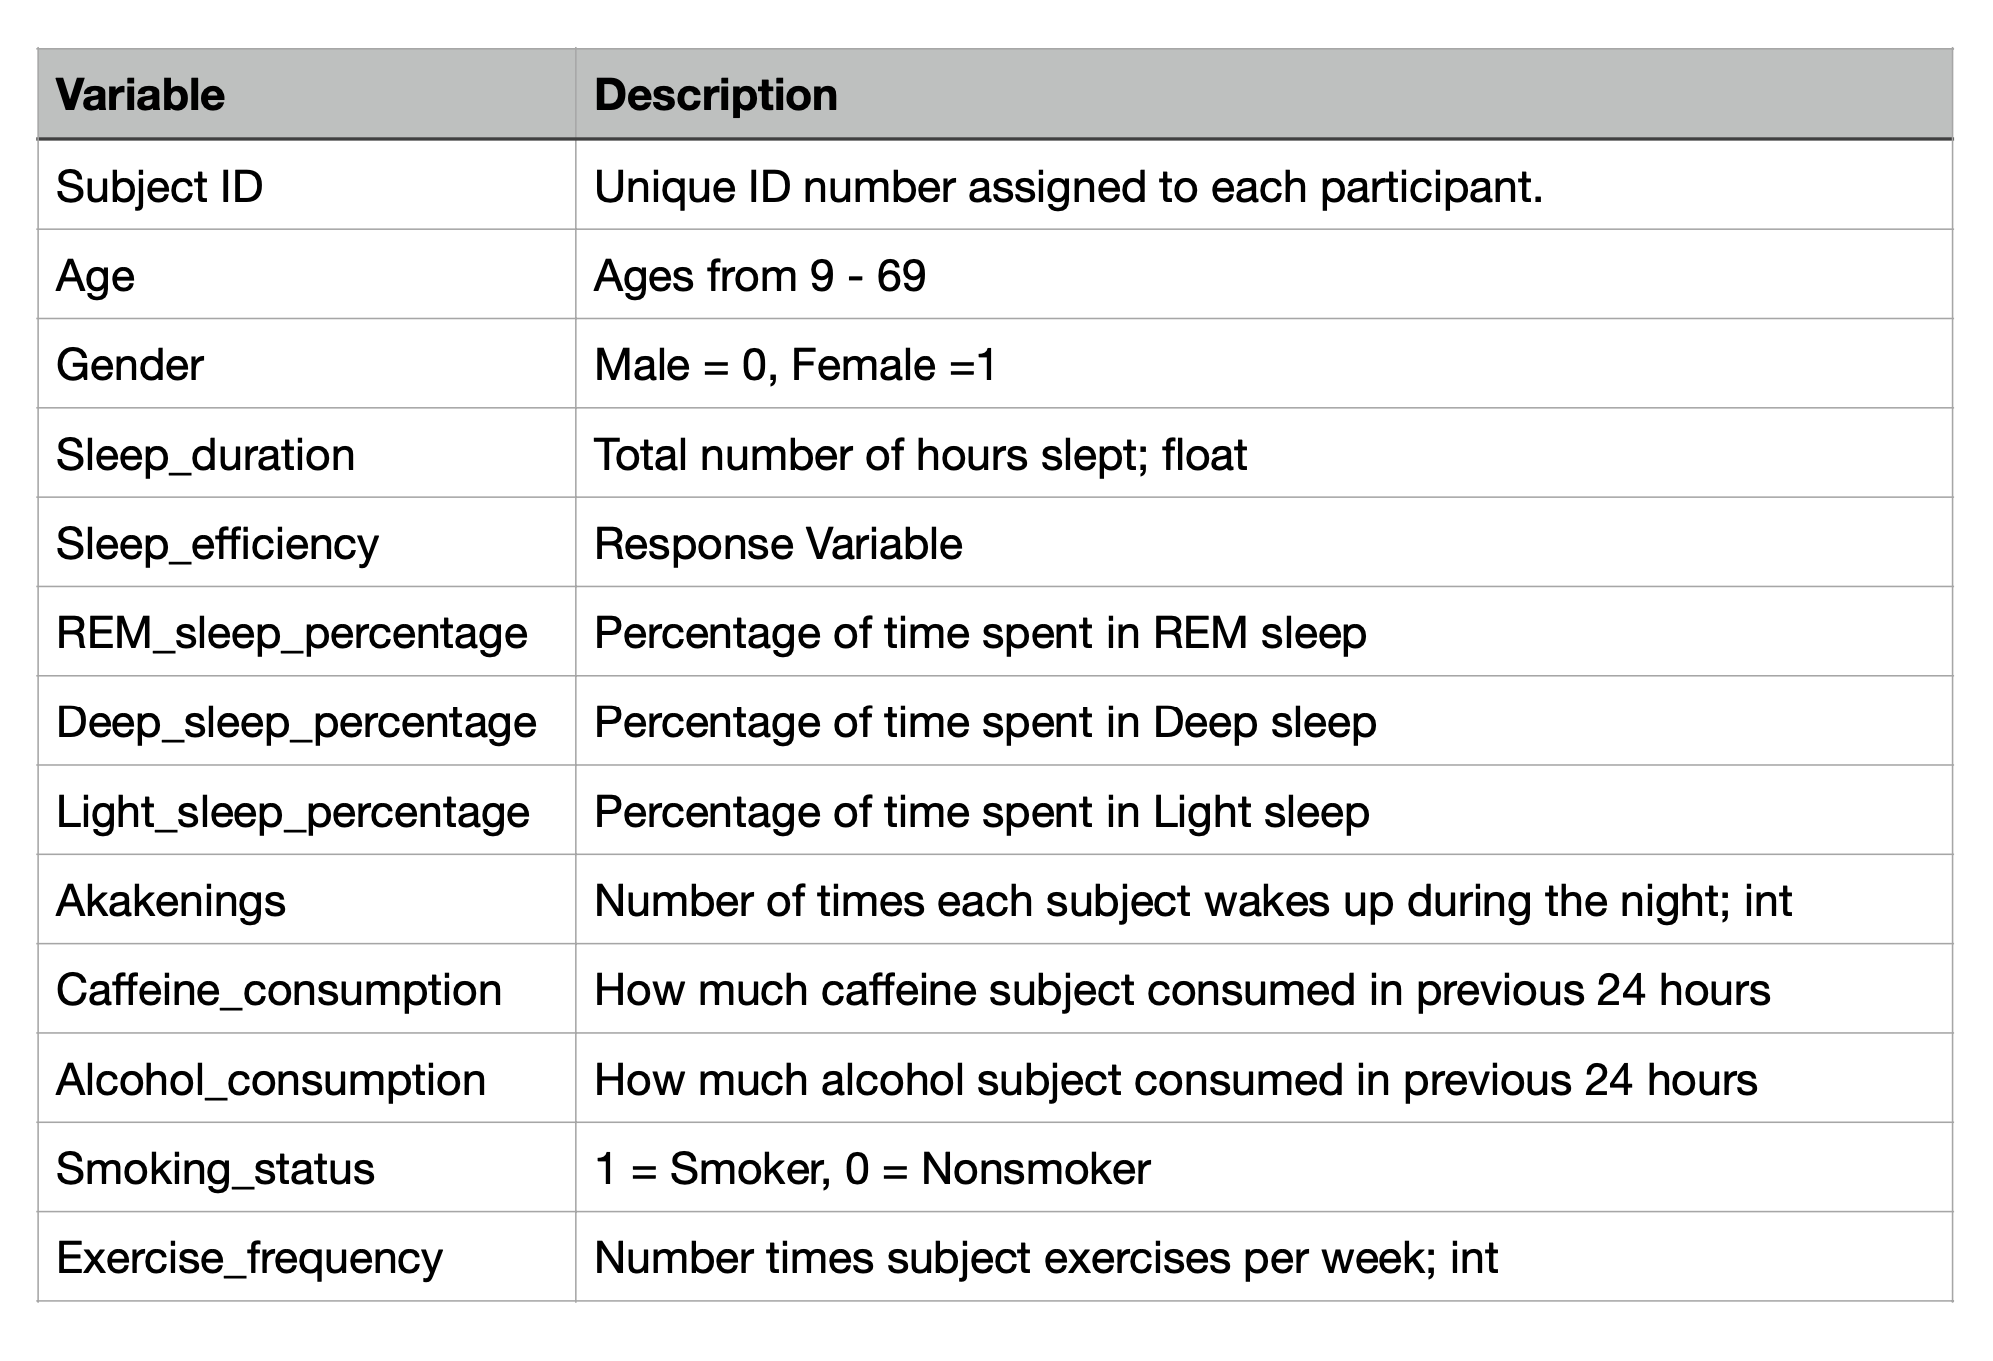

### 2. Finding and Understanding the Variables

Let's begin exploring the data by looking for missing values.

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      452 non-null    int64  
 1   Age                     452 non-null    int64  
 2   Gender                  452 non-null    int64  
 3   Bedtime                 452 non-null    object 
 4   Wakeup_time             452 non-null    object 
 5   Sleep_duration          452 non-null    float64
 6   Sleep_efficiency        452 non-null    float64
 7   REM_sleep_percentage    452 non-null    int64  
 8   Deep_sleep_percentage   452 non-null    int64  
 9   Light_sleep_percentage  452 non-null    int64  
 10  Awakenings              432 non-null    float64
 11  Caffeine_consumption    427 non-null    float64
 12  Alcohol_consumption     438 non-null    float64
 13  Smoking_status          452 non-null    int64  
 14  Exercise_frequency      446 non-null    fl

Notice that this dataset contains 452 observations. Of those, Awakenings, Caffeine_consumption, Alcohol_consumption, and Exercise_frequency are missing values. Next, let's find out the percentage of data missing from each of these.

In [129]:
percent_missing_awakenings = (1-432/452)*100
percent_missing_caffeine = (1-427/452)*100
percent_missing_alcohol = (1-438/452)*100
percent_missing_exercise = (1-446/452)*100

print("Percentage of missing Awakenings Values: {:.2f}".format(percent_missing_awakenings))
print("Percentage of missing Caffeine_consumption Values: {:.2f}".format(percent_missing_caffeine))
print("Percentage of missing Alcohol_consumption Values: {:.2f}".format(percent_missing_alcohol))
print("Percentage of missing Exercise_frequency Values: {:.2f}".format(percent_missing_exercise))

Percentage of missing Awakenings Values: 4.42
Percentage of missing Caffeine_consumption Values: 5.53
Percentage of missing Alcohol_consumption Values: 3.10
Percentage of missing Exercise_frequency Values: 1.33


### 3. Cleaning the Dataset

Keeping with the standard set in this course of dropping columns which are missing 5% or more values, we will drop Caffeine_consumption. We will also drop ID since it correlates with a row number and does not add any influence to our model. 

In [165]:
features_to_impute = ['Awakenings', 'Alcohol_consumption', 'Exercise_frequency']
features_to_throw = ['ID', 'Caffeine_consumption']
df = df.drop(columns = features_to_throw)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     452 non-null    int64  
 1   Gender                  452 non-null    int64  
 2   Bedtime                 452 non-null    object 
 3   Wakeup_time             452 non-null    object 
 4   Sleep_duration          452 non-null    float64
 5   Sleep_efficiency        452 non-null    float64
 6   REM_sleep_percentage    452 non-null    int64  
 7   Deep_sleep_percentage   452 non-null    int64  
 8   Light_sleep_percentage  452 non-null    int64  
 9   Awakenings              432 non-null    float64
 10  Alcohol_consumption     438 non-null    float64
 11  Smoking_status          452 non-null    int64  
 12  Exercise_frequency      446 non-null    float64
dtypes: float64(5), int64(6), object(2)
memory usage: 46.0+ KB


For the other three variables with missing values, Awakenings, Alcohol_consumption, and Exercise_frequency, we will replace the missing values with their corresponding mean values. First, let's double check their datatype:

In [112]:
for c in features_to_impute:
    print(c, len(df[c].unique()), df[c].dtype)

Awakenings 6 float64
Alcohol_consumption 7 float64
Exercise_frequency 7 float64


Now, let's replace those missing values with their mean and double check our work.

In [166]:
values = {"Awakenings": df["Awakenings"].mean(), "Alcohol_consumption": df["Alcohol_consumption"].mean(), "Exercise_frequency": df["Exercise_frequency"].mean()} 
df.fillna(value=values, inplace = True) 
for c in df.columns:
    print(c, df[c].isnull().sum())


Age 0
Gender 0
Bedtime 0
Wakeup_time 0
Sleep_duration 0
Sleep_efficiency 0
REM_sleep_percentage 0
Deep_sleep_percentage 0
Light_sleep_percentage 0
Awakenings 0
Alcohol_consumption 0
Smoking_status 0
Exercise_frequency 0


### 4. Identify Correlated Variables

Using both a correlation matrix and a heatmap from the seaborn library, we see below that Light_sleep_percentage and Deep_sleep_percnetage are collinear. This should come as no surprise since one individual cannot be both in deep sleep and in light sleep simutaneously. However, the third sleep percentage REM does not appear to be highly correlated with either of these two variables.  

Sleep efficiency is being used in this project as the response variable.

In [167]:
df.corr()

,Age,Gender,Sleep_duration,Sleep_efficiency,REM_sleep_percentage,Deep_sleep_percentage,Light_sleep_percentage,Awakenings,Alcohol_consumption,Smoking_status,Exercise_frequency
Age,1.000000,-0.244468,-0.062462,0.098357,0.042091,0.021730,-0.031905,-0.017468,0.046474,0.031237,0.071892
Gender,-0.244468,1.000000,0.044376,-0.010062,0.161102,-0.075939,0.040534,-0.074205,-0.058287,-0.143020,-0.230169
Sleep_duration,-0.062462,0.044376,1.000000,-0.027467,-0.015940,-0.037304,0.041804,0.004829,-0.045662,0.004211,-0.067903
Sleep_efficiency,0.098357,-0.010062,-0.027467,1.000000,0.062362,0.787335,-0.819204,-0.554498,-0.383671,-0.290026,0.257974
REM_sleep_percentage,0.042091,0.161102,-0.015940,0.062362,1.000000,-0.208159,-0.017462,-0.024992,-0.051709,0.032184,0.031165
Deep_sleep_percentage,0.021730,-0.075939,-0.037304,0.787335,-0.208159,1.000000,-0.974311,-0.300301,-0.355842,-0.226802,0.178281
Light_sleep_percentage,-0.031905,0.040534,0.041804,-0.819204,-0.017462,-0.974311,1.000000,0.312734,0.375662,0.224436,-0.189422
Awakenings,-0.017468,-0.074205,0.004829,-0.554498,-0.024992,-0.300301,0.312734,1.000000,0.198491,-0.020781,-0.212485
Alcohol_consumption,0.046474,-0.058287,-0.045662,-0.383671,-0.051709,-0.355842,0.375662,0.198491,1.000000,0.073629,0.006800
Smoking_status,0.031237,-0.143020,0.004211,-0.290026,0.032184,-0.226802,0.224436,-0.020781,0.073629,1.000000,-0.040535


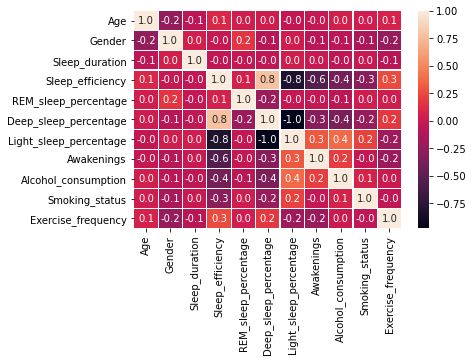

In [168]:
sns.heatmap(df.corr(), annot=True, fmt=".1f", linewidth=.2)

### 5. Choosing a Statistical Method

This is a regression problem. In order to understand the nature of the variables more, let's create a pair plot using the seaborn library.

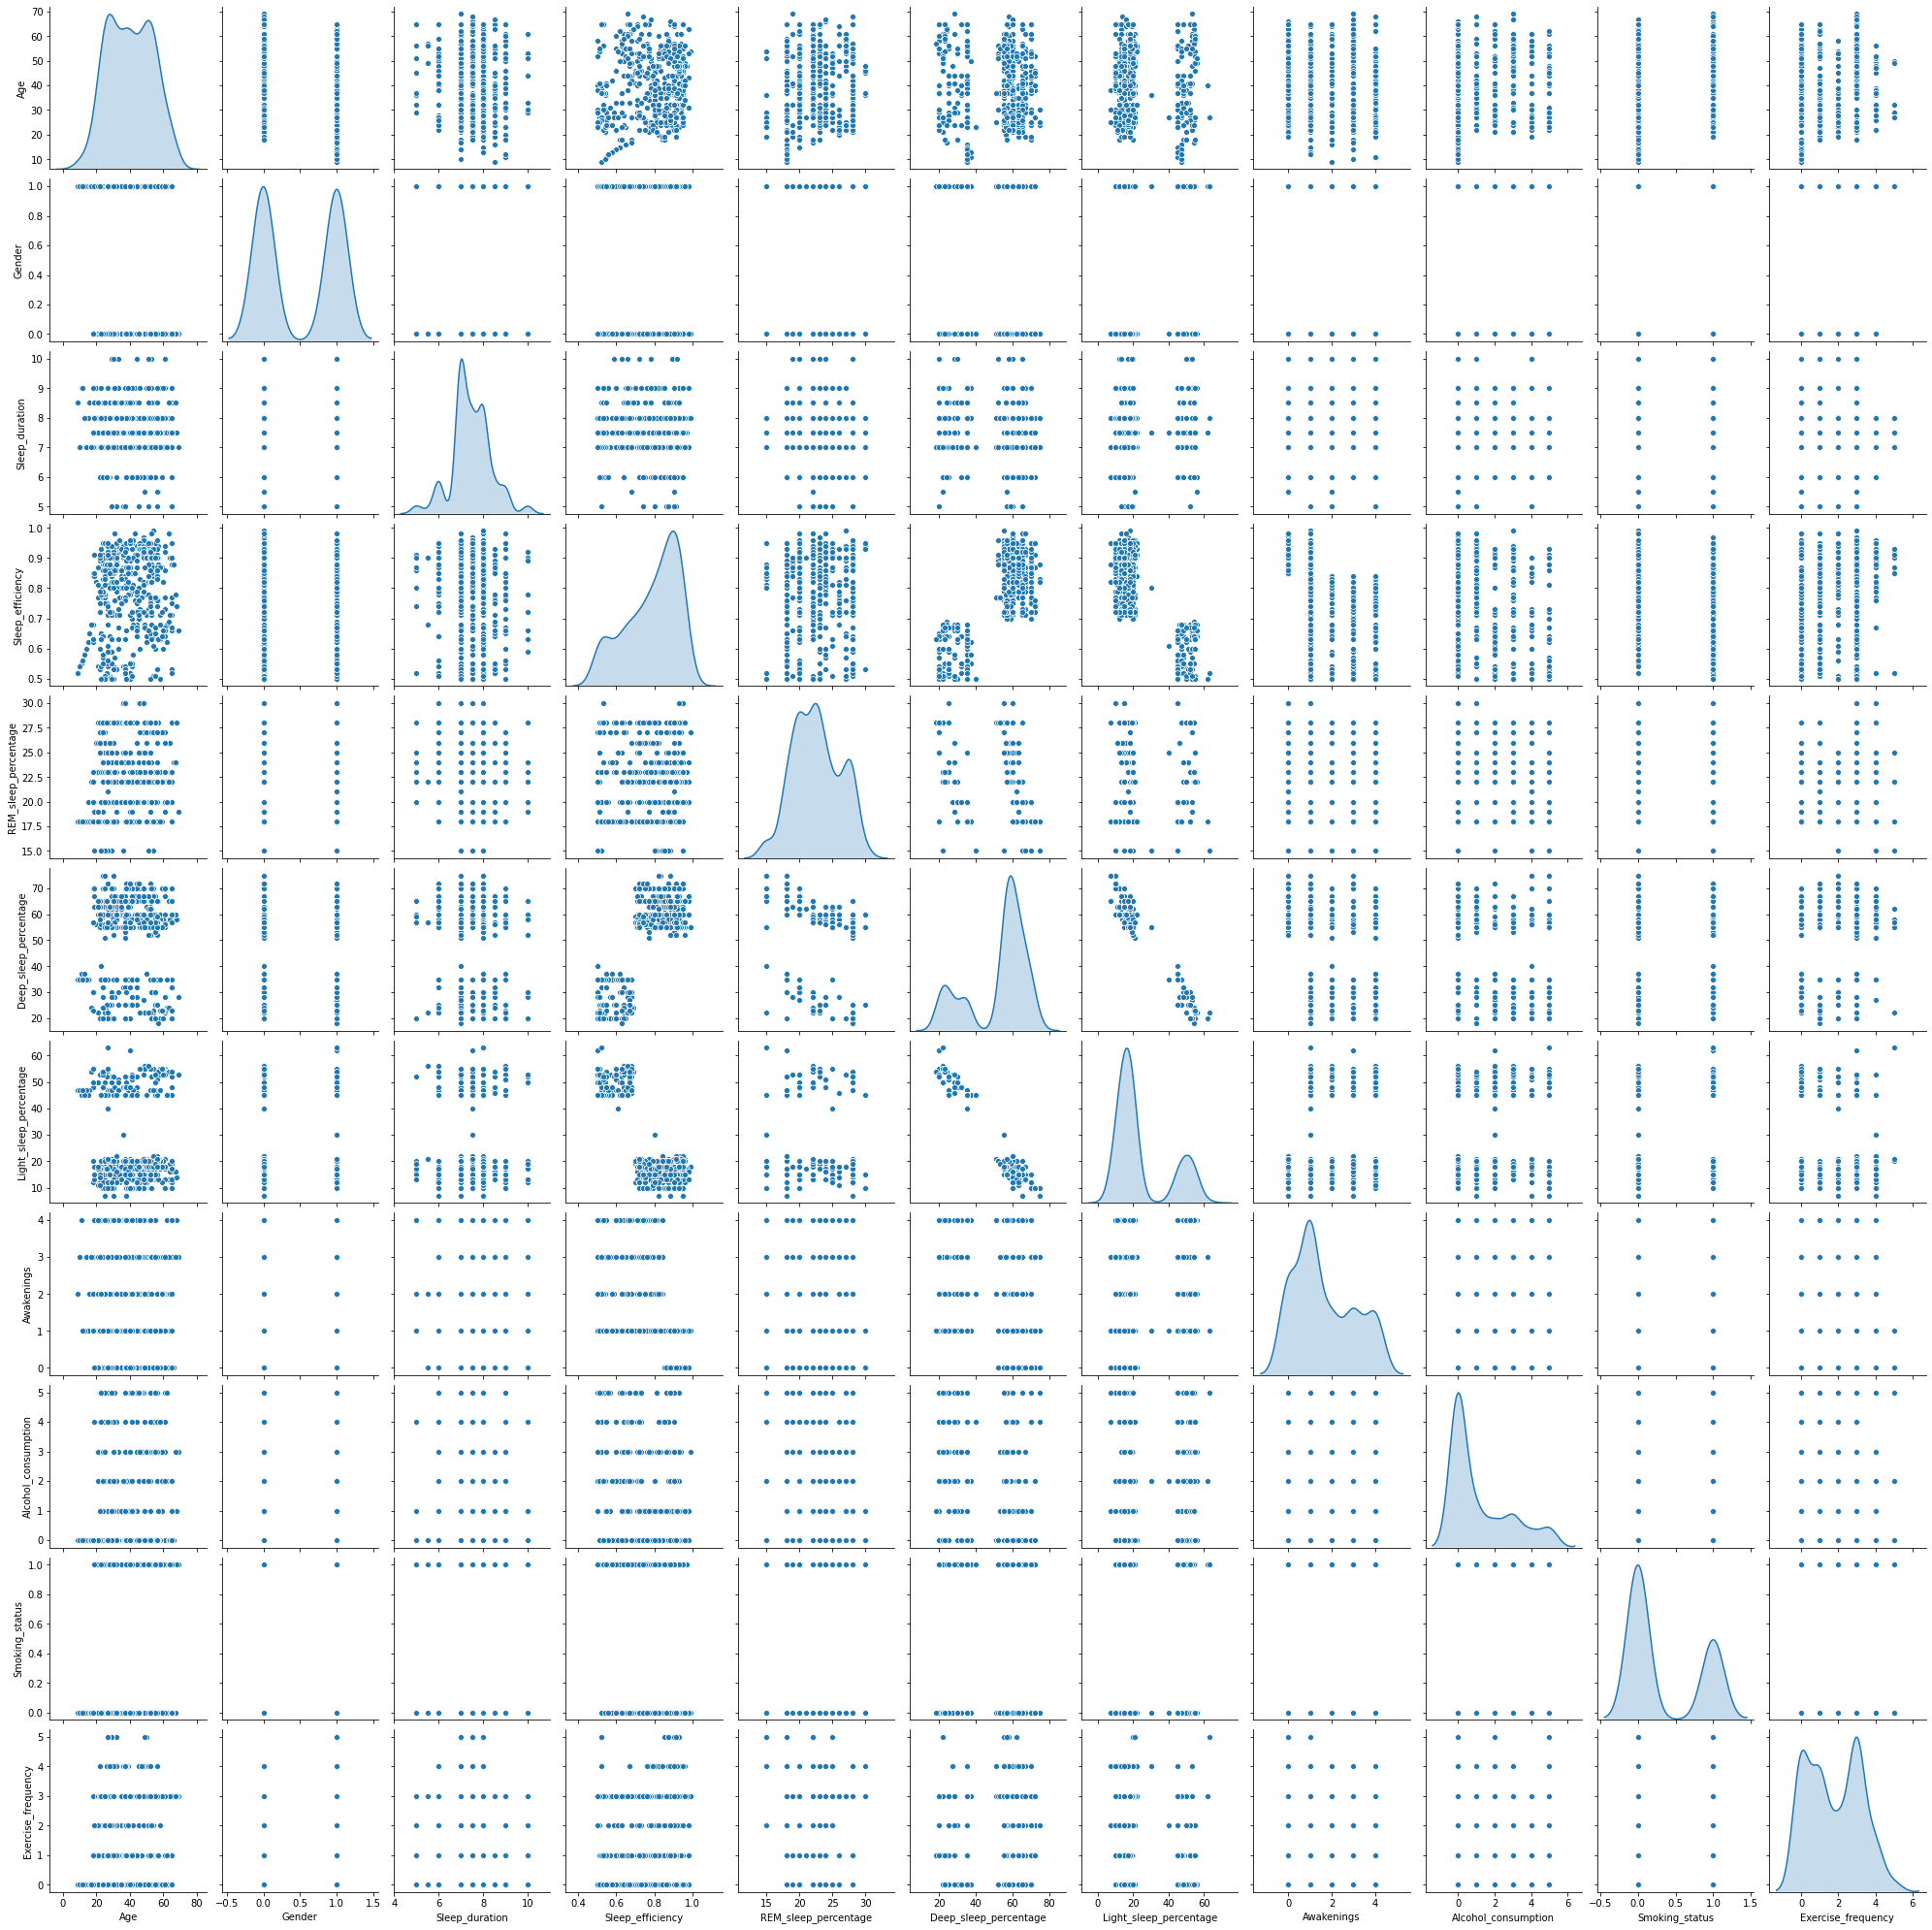

In [131]:
sns.pairplot(df, diag_kind = 'kde')

Many of the predictor variables look categorical. Clearly, gender is categorical and the KDE plot indicates that this sample has approximately equal numbers of men and women. Smoking status is also clearly, categorical with more non-smokers than smokers. As seen the table in Section 1, non-smokers were given a value of zero while smokers a value of 1.

Light and deep sleep percentages are numeric, but their KDE distirbutions suggest that observations fell more heavily into two bins for each of these predictor variables. 

There is nothing in the data to suggest non-linearlity. Therefore, we will not be fitting any polynomial terms to the model.

There is nothing in the data to suggest outliers either so we will not be removing observations at this point.

We are going to used the backward feature selection technique. Let's begin by constructing a multiple linear regression model, including all of the predictor variables plus an interaction term for deep and light sleep percentages using statsmodels.formula.api.ols.

In [169]:
model = smf.ols('Sleep_efficiency ~ Age +' + 'Gender+' + 'Sleep_duration+' + 'REM_sleep_percentage+' + 'Deep_sleep_percentage+' + 'Light_sleep_percentage+' + 'Awakenings+' + 'Alcohol_consumption+' + 'Smoking_status+' + 'Exercise_frequency+' + 'Deep_sleep_percentage*Light_sleep_percentage', data=df).fit() 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Sleep_efficiency   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     180.9
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          3.88e-149
Time:                        20:57:09   Log-Likelihood:                 631.74
No. Observations:                 452   AIC:                            -1241.
Df Residuals:                     441   BIC:                            -1196.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

The p-values for Gender and Sleep_duration are quite high. The interaction term also has a substantial p-value. First let's try removing Gender and Sleep_duration:

In [170]:
model2 = smf.ols('Sleep_efficiency ~ Age +' + 'REM_sleep_percentage+' + 'Deep_sleep_percentage+' + 'Light_sleep_percentage+' + 'Awakenings+' + 'Alcohol_consumption+' + 'Smoking_status+' + 'Exercise_frequency+' + 'Deep_sleep_percentage*Light_sleep_percentage', data=df).fit() 
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:       Sleep_efficiency   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     226.9
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          1.97e-151
Time:                        20:57:45   Log-Likelihood:                 631.60
No. Observations:                 452   AIC:                            -1245.
Df Residuals:                     443   BIC:                            -1208.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

The R-squared value didn't change. The interaction term's p-value decreased slighlty, but is still high. Let's see if removing that interaction improves the model's fit:

In [171]:
model3 = smf.ols('Sleep_efficiency ~ Age +' + 'REM_sleep_percentage+' + 'Deep_sleep_percentage+' + 'Light_sleep_percentage+' + 'Awakenings+' + 'Alcohol_consumption+' + 'Smoking_status+' + 'Exercise_frequency', data=df).fit() 
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:       Sleep_efficiency   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     258.4
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          3.40e-152
Time:                        20:58:13   Log-Likelihood:                 630.51
No. Observations:                 452   AIC:                            -1245.
Df Residuals:                     444   BIC:                            -1212.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

Removing the interaction term had negligible effect on R-squared or adjusted R-squared; however, the p-values are now good.

Now, let's look for high leverage points using statsmodel.api.

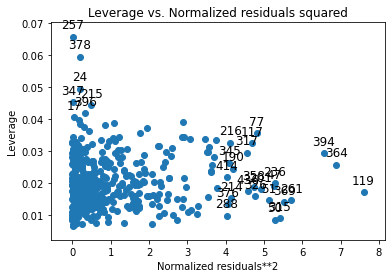

In [172]:
sm.graphics.plot_leverage_resid2(model2) 
plt.show()

The graph indicates many high leverage points. Let's remove some of these and try fitting our model again.  

In [173]:
df = df.drop(labels = [257,378,24,347,215,396,17,394,364,119,77,117,216,317,345,236,190,414], axis = 0)
model4 = smf.ols('Sleep_efficiency ~ Age +' + 'REM_sleep_percentage+' + 'Deep_sleep_percentage+' + 'Light_sleep_percentage+' + 'Awakenings+' + 'Alcohol_consumption+' + 'Smoking_status+' + 'Exercise_frequency', data=df).fit() 
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:       Sleep_efficiency   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     275.3
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          1.02e-153
Time:                        20:58:54   Log-Likelihood:                 628.67
No. Observations:                 434   AIC:                            -1241.
Df Residuals:                     426   BIC:                            -1209.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

R-squared and adjusted R-squared have improved. The p-value for Alcohol_consumption is now a little high. Let's see if removing that predictor improves the fit of our model.

In [174]:
model_final = smf.ols('Sleep_efficiency ~ Age +' + 'REM_sleep_percentage+' + 'Deep_sleep_percentage+' + 'Light_sleep_percentage+' + 'Awakenings+' + 'Smoking_status+' + 'Exercise_frequency', data=df).fit() 
print(model_final.summary())

                            OLS Regression Results                            
Dep. Variable:       Sleep_efficiency   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     319.9
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          1.64e-154
Time:                        20:59:06   Log-Likelihood:                 627.56
No. Observations:                 434   AIC:                            -1241.
Df Residuals:                     427   BIC:                            -1213.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

The p-values are now good, but there's a slight decrease in R-squared. 

### Visualize and Analyze Results

Below we plot the adjusted R-squared values versus the number of predictors k. In order to have the same k values as before and after the leverage points were removed, some outside work was performed. In the with model before removing the leverage points, Exercise_frequency, the feature with the largest p-value, was removed in order to assess $k=7$. For after the leverage points removal, the same predictor varables as were used in model and model2 were used. For ease of reading this paper, these computations have been omitted.

Text(0, 0.5, 'R-squared Adjusted')

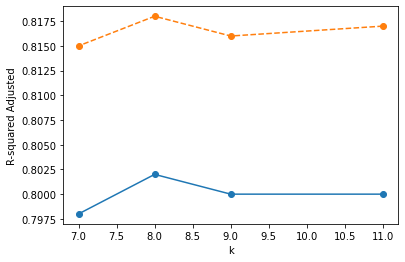

In [175]:
k = [11,9,8,7]
adjr2_with_lev = [.8,.8,.802,.798]
adjr2_without_lev = [.817, .816, .818, .815]
plt.plot(k, adjr2_with_lev, 'o', ls = '-')
plt.plot(k, adjr2_without_lev, 'o', ls = '--')
plt.xlabel('k')
plt.ylabel('R-squared Adjusted')

Removing leverage points from this dataset had more influence on the Sleep_efficiency than removing features did. Whether or not leverage points were included, the best model contained 8 features: Age, REM_sleep_percentage, Deep_sleep_percentage, Light_sleep_percentage, Awakenings, Alcohol_consumption, Smoking_status and Exercise_frequency.

In [177]:
allowed_factors = ['Age', 'REM_sleep_percentage', 'Deep_sleep_percentage', 'Light_sleep_percentage', 'Awakenings', 'Alcohol_consumption', 'Smoking_status', 'Exercise_frequency']
best = ['',0]
for p in allowed_factors:
    model = smf.ols(formula='Sleep_efficiency~'+p, data=df).fit() 
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('best:',best)

Age 0.00987329434169859
REM_sleep_percentage 0.005028312096599263
Deep_sleep_percentage 0.6228650215846004
Light_sleep_percentage 0.6774382093949173
Awakenings 0.33583160763021047
Alcohol_consumption 0.14699552384446923
Smoking_status 0.07489209563444288
Exercise_frequency 0.07939652809341702
best: ['Light_sleep_percentage', 0.6774382093949173]


Looking at these 8 features and comparing their individual R-squared values, Light_sleep_percentage appears to be the best indicator of Sleep_efficiency followed by Deep_sleep_percentage and Awakenings. From this small sample size of only 434 subjects (once high leverage points were removed), it appears that the quality of sleep is more important in terms of sleep efficiency than duration of sleep, age or lifestyle habits.